In [36]:
import numpy as np
import statsmodels.tsa.stattools as stm
import scipy.stats as sc
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.cluster import KMeans, DBSCAN
import findspark
from pyspark.sql import SparkSession

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

findspark.init()
spark = SparkSession.builder.appName("Price").getOrCreate()

def sql_to_df(command: str) -> pd.DataFrame:
    return spark.sql(command).toPandas()

In [37]:
price_data = spark.read.csv(path="../../data/clean_data/clean_car_price.csv", header=True, inferSchema=True)

In [38]:
price_data.createOrReplaceTempView("price")

In [39]:
price_data.count()

6925

In [40]:
price_data.show()

+---+--------------------+----+------------------+---------+------+-----------+------------+------------+
|_c0|                name|year|     selling_price|km_driven|  fuel|seller_type|transmission|       owner|
+---+--------------------+----+------------------+---------+------+-----------+------------+------------+
|  0|Maruti Swift Dzir...|2014|            4950.0|   145500|Diesel| Individual|      Manual| First Owner|
|  1|Skoda Rapid 1.5 T...|2014|4069.9999999999995|   120000|Diesel| Individual|      Manual|Second Owner|
|  2|Honda City 2017-2...|2006|            1738.0|   140000|Petrol| Individual|      Manual| Third Owner|
|  3|Hyundai i20 Sport...|2010|            2475.0|   127000|Diesel| Individual|      Manual| First Owner|
|  4|Maruti Swift VXI ...|2007|            1430.0|   120000|Petrol| Individual|      Manual| First Owner|
|  5|Hyundai Xcent 1.2...|2017|            4840.0|    45000|Petrol| Individual|      Manual| First Owner|
|  6|Maruti Wagon R LX...|2007|            105

In [41]:
filtered = sql_to_df('''select year, 
                        avg(selling_price) as SP_avg, 
                        max(selling_price) as SP_max, 
                        min(selling_price) as SP_min, 
                        sum(selling_price) as SP_total
                        from price
                        group by year
                        order by year asc''')
filtered

,year,SP_avg,SP_max,SP_min,SP_total
0,1983,3300.000000,3300.0,3300.000,3300.000
1,1991,605.000000,605.0,605.000,605.000
2,1994,968.000000,1320.0,495.000,2904.000
3,1995,1182.500000,1760.0,605.000,2365.000
4,1996,898.333333,1793.0,440.000,2695.000
5,1997,991.999000,3300.0,329.989,10911.989
6,1998,804.100000,2310.0,385.000,8041.000
7,1999,786.176471,1705.0,440.000,13365.000
8,2000,990.526350,2200.0,330.000,19810.527
9,2001,519.423667,825.0,330.000,4674.813


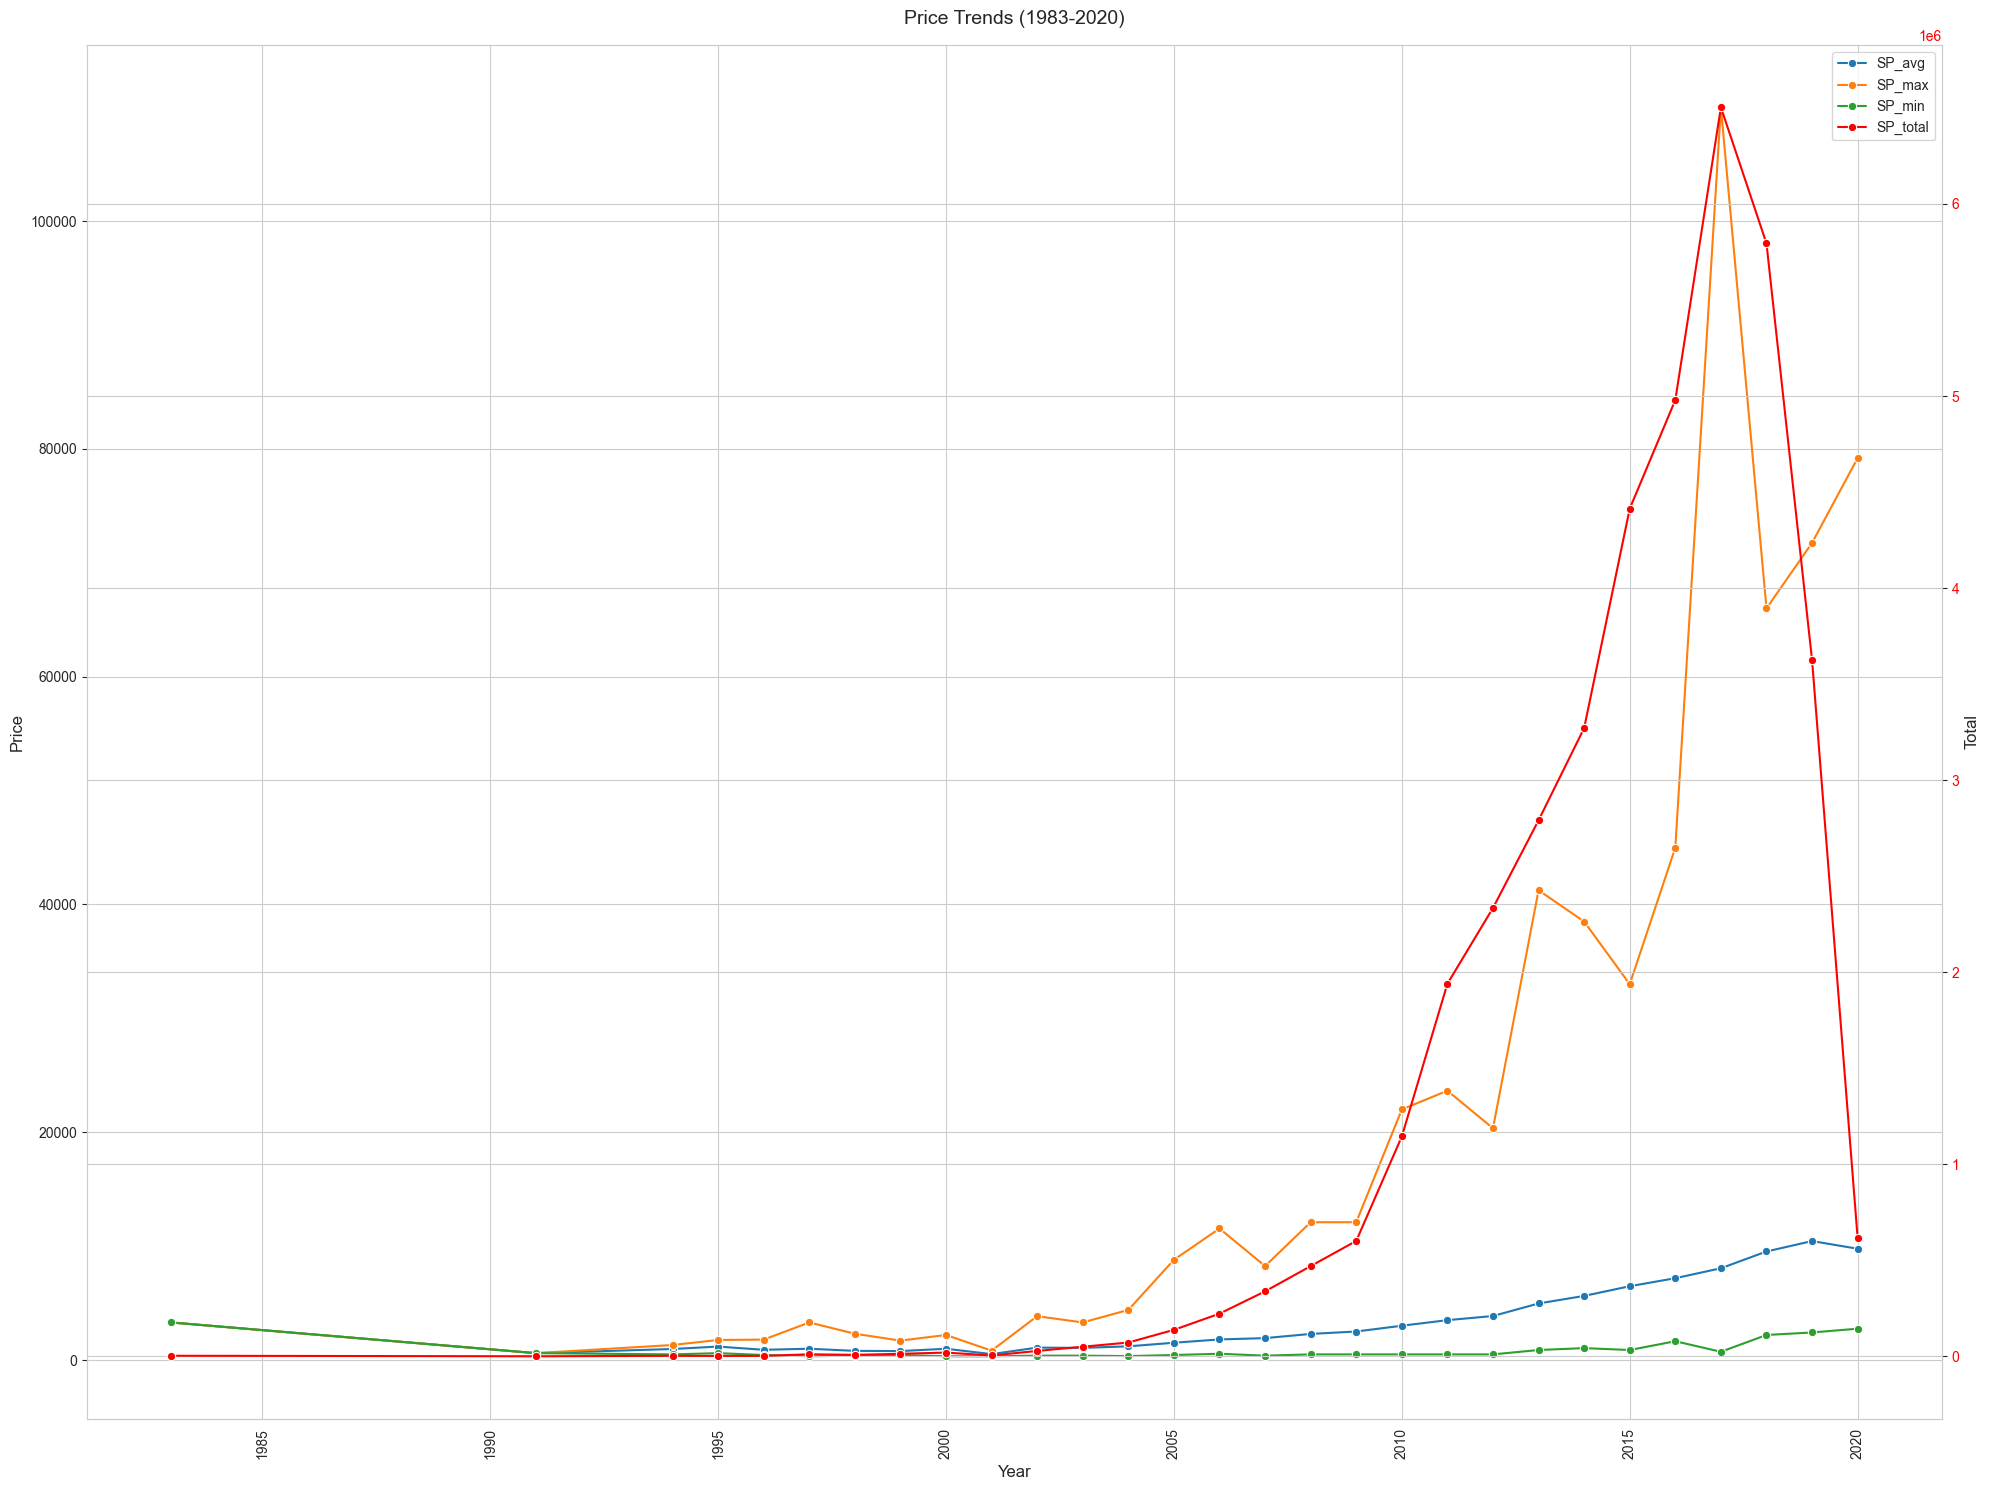

In [42]:
fig, ax1 = plt.subplots(figsize=(20, 15))

ax2 = ax1.twinx()

sb.set_style("whitegrid")

df_prices = filtered.melt(id_vars=['year'],
                    value_vars=['SP_avg', 'SP_max', 'SP_min'],
                    var_name='Metric',
                    value_name='Price')

sb.lineplot(data=df_prices,
             x='year',
             y='Price',
             hue='Metric',
             marker='o',
             markersize=6,
             ax=ax1)

sb.lineplot(data=filtered,
             x='year',
             y='SP_total',
             color='red',
             marker='o',
             markersize=6,
             ax=ax2,
             label='SP_total')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Price', fontsize=12)
ax1.tick_params(axis='x', rotation=90)

ax2.set_ylabel('Total', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Price Trends (1983-2020)', pad=15, fontsize=14)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

ax1.get_legend().remove()

plt.tight_layout()

plt.show()

In [45]:
filtered = sql_to_df('''select selling_price, km_driven, fuel from price''')
filtered

,selling_price,km_driven,fuel
0,4950.0,145500,Diesel
1,4070.0,120000,Diesel
2,1738.0,140000,Petrol
3,2475.0,127000,Diesel
4,1430.0,120000,Petrol
...,...,...,...
6920,2860.0,50000,Petrol
6921,5225.0,80000,Diesel
6922,3520.0,110000,Petrol
6923,1485.0,119000,Diesel


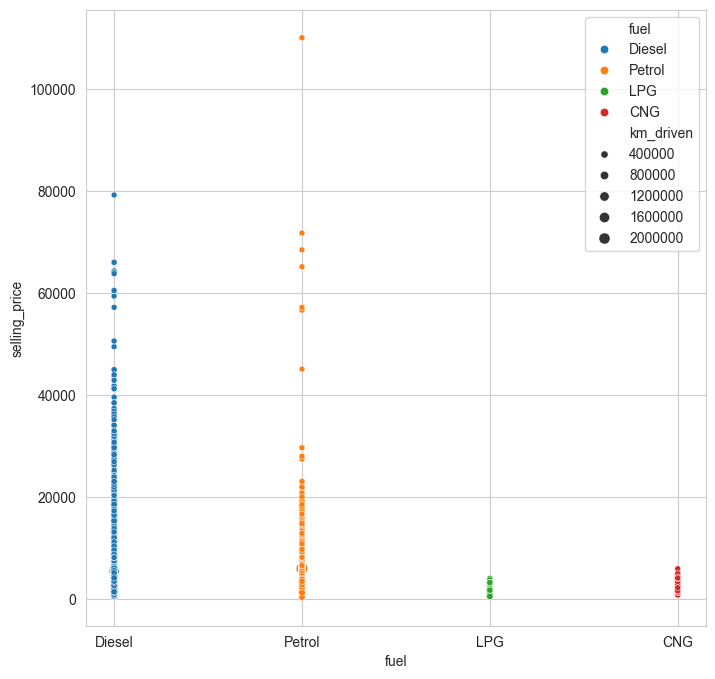

In [50]:
plt.figure(figsize=(8,8))
sb.scatterplot(data=filtered, x='fuel', y='selling_price', size='km_driven' ,hue='fuel')
plt.show()

In [51]:
filtered = sql_to_df('''select owner, seller_type, selling_price from price''')
filtered

,owner,seller_type,selling_price
0,First Owner,Individual,4950.0
1,Second Owner,Individual,4070.0
2,Third Owner,Individual,1738.0
3,First Owner,Individual,2475.0
4,First Owner,Individual,1430.0
...,...,...,...
6920,Second Owner,Individual,2860.0
6921,Second Owner,Individual,5225.0
6922,First Owner,Individual,3520.0
6923,Fourth & Above Owner,Individual,1485.0


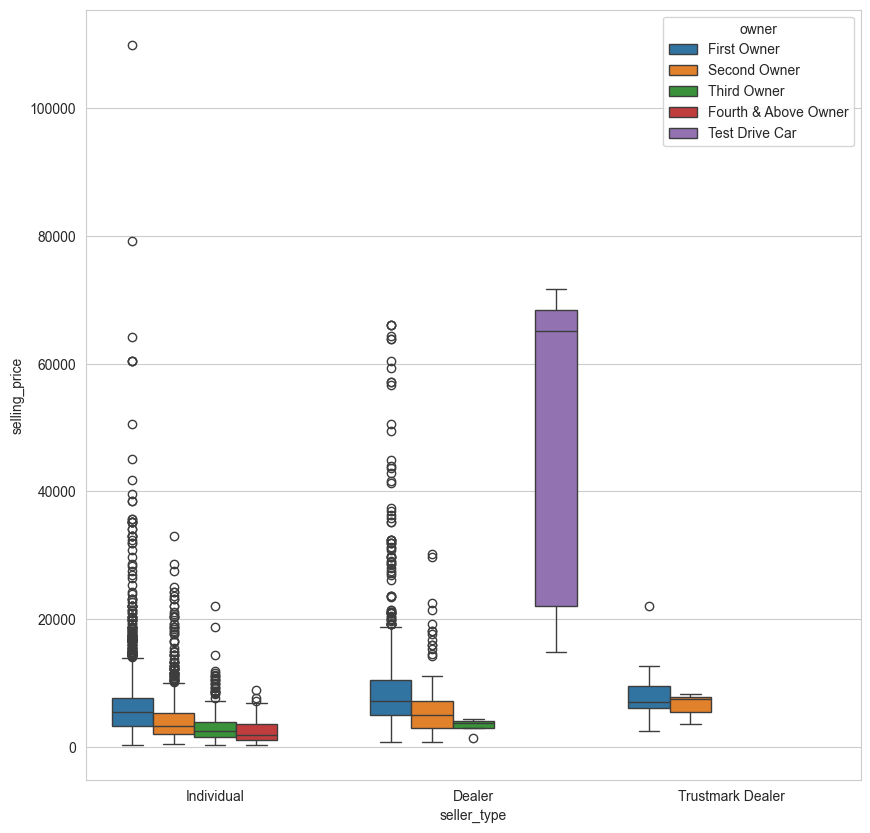

In [52]:
plt.figure(figsize=(10,10))
sb.boxplot(data=filtered, x='seller_type', y='selling_price', hue='owner')
plt.show()

In [53]:
filtered = sql_to_df('''select transmission, selling_price from price''')
filtered

,transmission,selling_price
0,Manual,4950.0
1,Manual,4070.0
2,Manual,1738.0
3,Manual,2475.0
4,Manual,1430.0
...,...,...
6920,Manual,2860.0
6921,Manual,5225.0
6922,Manual,3520.0
6923,Manual,1485.0


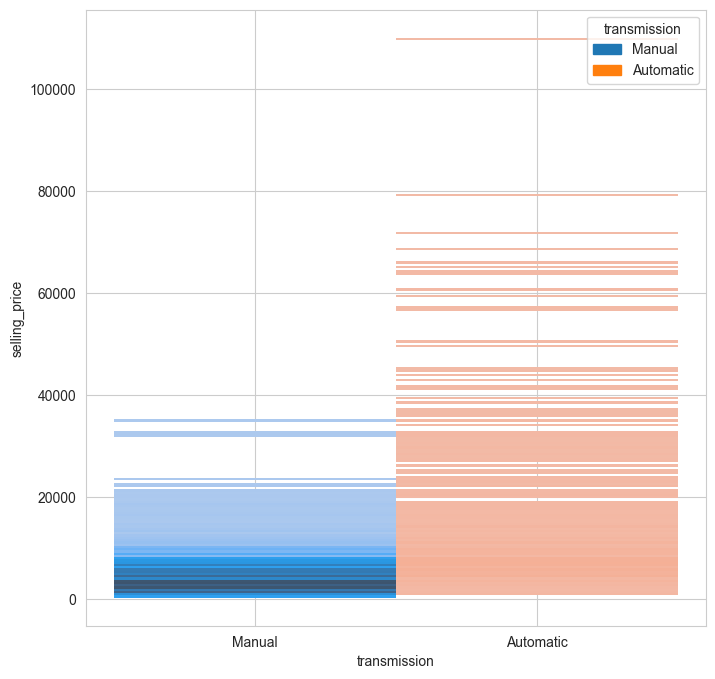

In [55]:
plt.figure(figsize=(8,8))
sb.histplot(data=filtered, x='transmission', y='selling_price', hue='transmission')
plt.show()

In [56]:
spark.stop()